In [1]:
import os
from typing import Optional, Union, Tuple, Dict
from random import randint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import AUC, PrecisionAtRecall

import numpy as np

from PIL import Image
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes


In [4]:

_PATH = '/Users/Aviad.Klein/Documents/learning/cv_class_for_kids/animals'
_MODEL_PATH = '/Users/Aviad.Klein/Documents/learning/cv_class_for_kids/models'

datasets = ['inf', 'train', 'val'] # there are 3 datasets that come with the Animals dataset
dataset_to_path = {k:f'{_PATH}/{k}' for k in datasets}

# these are the classes in the train and val datasets
# tensorflow uses the Generator classes and assigns a class based on the order of the directories
classes = ['cat', 'dog', 'horse', 'lion', 'elephant'] 


In [5]:
def get_dataset_path(dataset: str='train') -> str:
    """returns the path of a specific dataset (train, val, inf) as str"""
    assert dataset in datasets, f"unknown dataset {dataset}, available options are: {datasets}"
    return f'{_PATH}/{dataset}'

def get_class_path(clazz: str, dataset: str='train') -> str:
    """returns the path of a specific class under a spcific dataset"""
    assert clazz in classes, f"unknown class {clazz}, available options are: {classes}"
    return f'{get_dataset_path(dataset)}/{clazz}'

def get_image_path(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None) -> str:
    """will return a file of an image, if file is None, will choose a random image
    if file is an integer will return the image in the integer's index

    returns the path to the image
    """
    path = get_class_path(clazz, dataset)
    file_list = os.listdir(path) 
    size = len(file_list)
    if file is None:
        file = randint(0, size-1)
        return f'{path}/{file_list[file]}'
    elif isinstance(file, int):
        return f'{path}/{file_list[file]}'
    elif isinstance(file, str):
        assert file in file_list
        return f'{path}/{file}'
    else:
        raise ValueError()
    
def get_image_array(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None, add_batch_axis: bool=False) -> Tuple[np.ndarray, str]:
    """returns a tuple of:
        image as an array of shape (x,x,3)
        path to the image
    if add_batch_axis is set to True will expand the shape to (batch,x,x,3)
    """
    path = get_image_path(clazz, dataset, file)
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image.numpy()
    if add_batch_axis:
        image = np.expand_dims(image, axis=0)
    return image, path

def show_image(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None, axis: bool=False):
    """plots an image from a specific class and dataset, can also specify file (see get_image_path)"""
    image_array, path = get_image_array(clazz, dataset, file)
    print(path)
    plt.imshow(image_array)
    if axis == False:
        plt.axis('off')
    plt.show()

def show_image_channels(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None):
    """plots the image alongside it's rgb channels"""
    image_array, path = get_image_array(clazz, dataset, file)
    image_array[image_array < 0] = 0.
    image_array = image_array / image_array.max()
    print(path)
    fig = plt.figure(figsize=(7,7))
    ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8], pad=0.0)
    ax.imshow_rgb(image_array[:,:,0], image_array[:,:,1], image_array[:,:,2])

    plt.show()

def image_adjusted_for_model(target_size: Tuple[int, int], clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None) -> np.ndarray:
    img = image.load_img(get_image_path(clazz=clazz, dataset=dataset, file=file), target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255. 
    return img_array

def predict(model: Model, clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None) -> np.ndarray:
    img = image_adjusted_for_model(model.input_shape[1:3], clazz=clazz, dataset=dataset, file=file)
    y_hat = model.predict(img).reshape(-1)
    assert y_hat.size == len(classes)
    return y_hat

def plot_predict(model: Model, index2class: Dict[int, str], clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None):
    """plots the image and next to it, a bar chart of the final activation layer"""
    image_array, path = get_image_array(clazz, dataset, file)
    filename = path.split('/')[-1]
    y_hat = predict(model, clazz, dataset, file)
    index = np.argmax(y_hat)
    clazz = index2class[index]
    _, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].imshow(image_array)
    ax[0].set_title(f'class={clazz[::-1]}, {filename=}')
    ax[1].bar(np.arange(5), height=y_hat)
    ax[1].set_xticks([0,1,2,3,4])
    ax[1].set_xticklabels([index2class[i][::-1] for i in [0,1,2,3,4]])
    
    plt.show()

/Users/Aviad.Klein/Documents/learning/cv_class_for_kids/animals/train/dog/dog776.jpg


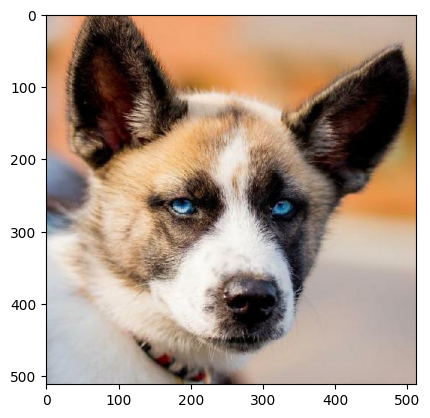

In [6]:
show_image('dog', file='dog776.jpg', axis=True)

/Users/Aviad.Klein/Documents/learning/cv_class_for_kids/animals/train/dog/dog776.jpg


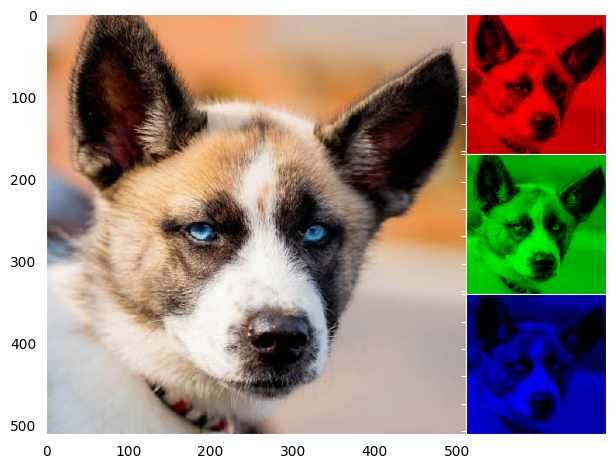

In [7]:
show_image_channels('dog', file='dog776.jpg')

In [36]:
# Model configuration
input_shape = (64, 64, 3)  # Adjust size and channels to match your images
num_classes = 5
batch_size = 32
epochs = 30

In [37]:
# Generators - these objects read files endlessly from directories
# they make sure to scale, distort, flip or do whatever

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories and resize them
train_generator = train_datagen.flow_from_directory(
    get_dataset_path('train'),
    target_size=input_shape[:2],  # Resize images to 64x64
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    get_dataset_path('val'),
    target_size=input_shape[:2],  # Resize images to 64x64
    batch_size=batch_size,
    class_mode='categorical')

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


In [113]:
index2class = {v: k for k, v in train_generator.class_indices.items()}
index2class_hebrew = {}

for k, v in index2class.items():
    match v:
        case 'cat':
            index2class_hebrew[k] = 'חתול'
        case 'dog':
            index2class_hebrew[k] = 'כלב'
        case 'horse':
            index2class_hebrew[k] = 'סוס'
        case 'lion':
            index2class_hebrew[k] = 'אריה'
        case 'elephant':
            index2class_hebrew[k] = 'פיל'

index2class_hebrew  
    

{0: 'חתול', 1: 'כלב', 2: 'פיל', 3: 'סוס', 4: 'אריה'}

In [38]:
# Model

# Define the CNN model
model = Sequential()

# First convolutional layer with ReLU activation and max pooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer with ReLU activation and max pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and add dropout
model.add(Flatten())
model.add(Dropout(0.5))

# Dense layer
model.add(Dense(128, activation='relu'))

# Output layer with softmax activation
model.add(Dense(num_classes, activation='softmax'))

# Set the model metrics
metrics=['accuracy', AUC(name='auc', multi_label=True), 
         PrecisionAtRecall(name='Prec@Rec(0.8)',recall=0.8), 
         PrecisionAtRecall(name='Prec@Rec(0.9)', recall=0.9)]

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

# Summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_5 (Dropout)         (None, 12544)            

In [39]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=epochs, validation_data=val_generator)

Epoch 1/30
100/100 [==============================] - 10s 99ms/step - loss: 1.3928 - accuracy: 0.4078 - auc: 0.7384 - Prec@Rec(0.8): 0.2899 - Prec@Rec(0.9): 0.2567 - val_loss: 1.0792 - val_accuracy: 0.5919 - val_auc: 0.8883 - val_Prec@Rec(0.8): 0.4268 - val_Prec@Rec(0.9): 0.3523
Epoch 2/30
100/100 [==============================] - 10s 99ms/step - loss: 0.9484 - accuracy: 0.6384 - auc: 0.8807 - Prec@Rec(0.8): 0.5089 - Prec@Rec(0.9): 0.4029 - val_loss: 0.8867 - val_accuracy: 0.6513 - val_auc: 0.9167 - val_Prec@Rec(0.8): 0.5343 - val_Prec@Rec(0.9): 0.4335
Epoch 3/30
100/100 [==============================] - 9s 92ms/step - loss: 0.8248 - accuracy: 0.6822 - auc: 0.9062 - Prec@Rec(0.8): 0.5906 - Prec@Rec(0.9): 0.4775 - val_loss: 0.6935 - val_accuracy: 0.7388 - val_auc: 0.9370 - val_Prec@Rec(0.8): 0.6826 - val_Prec@Rec(0.9): 0.5692
Epoch 4/30
100/100 [==============================] - 10s 95ms/step - loss: 0.7357 - accuracy: 0.7316 - auc: 0.9242 - Prec@Rec(0.8): 0.6505 - Prec@Rec(0.9): 0.51

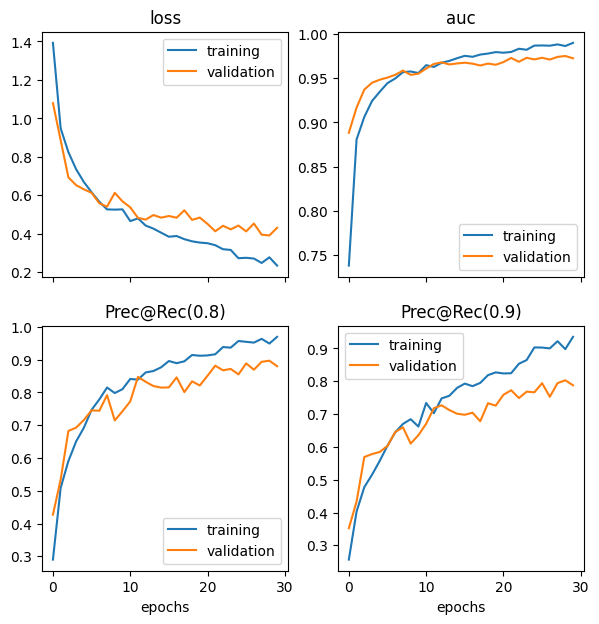

In [40]:
fig, ax = plt.subplots(2,2,figsize=(7,7),sharex=True)
ax = np.ravel(ax)
for i, metric in enumerate(['loss', 'auc', 'Prec@Rec(0.8)', 'Prec@Rec(0.9)']):
    ax[i].plot(history.history[metric], label='training')
    ax[i].plot(history.history[f'val_{metric}'], label='validation')
    if i > 1:
        ax[i].set_xlabel('epochs')
    ax[i].set_title(metric)
    ax[i].legend()
plt.show()

In [41]:
model.save(f'{_MODEL_PATH}/model_v1.keras')

In [68]:
eval = {k: v for k, v in zip(model.metrics_names, model.evaluate(val_generator))}
eval


47/47 [==============================] - 2s 52ms/step - loss: 0.4313 - accuracy: 0.8417 - auc: 0.9724 - Prec@Rec(0.8): 0.8802 - Prec@Rec(0.9): 0.7875


{'loss': 0.43125882744789124,
 'accuracy': 0.8416833877563477,
 'auc': 0.9723572731018066,
 'Prec@Rec(0.8)': 0.8802351355552673,
 'Prec@Rec(0.9)': 0.7875072956085205}

In [179]:
get_feature_array(activations, 0, 10).shape

(62, 62)

1/1 [==============================] - 0s 9ms/step


TypeError: unhashable type: 'numpy.ndarray'

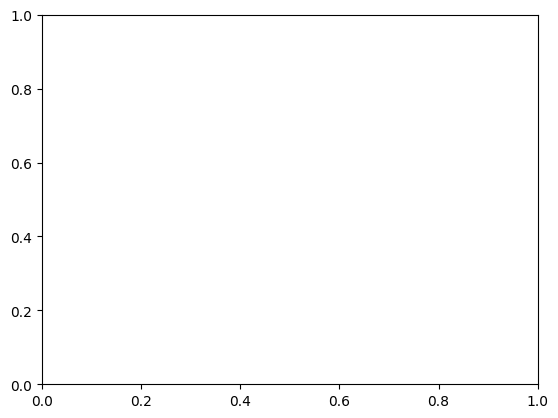

: 

In [186]:
# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")


# Capture frame-by-frame
ret, frame = cap.read()


# Convert the frame to RGB
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
rgb_input = cv2.resize(rgb_frame, model.input_shape[1:3])
rgb_input = np.expand_dims(rgb_input, axis=0) # Add batch axis

pred = model.predict(rgb_input)
activations = activation_model.predict(rgb_input)

feature_array = get_feature_array(activations, 0, 0)


plt.imshow('original', rgb_input)
plt.imshow('activation (0,0)', feature_array)

cap.release()
cv2.destroyAllWindows() 
